In [1]:
import pandas as pd
from dataset_postprocessors import CustomMaskPostprocessor, HeartRateInterpolationPostprocessor

df = pd.read_parquet('/mnt/shared/mhc_dataset_out/splits/test_dataset.parquet')
standardization_df = pd.read_csv("/mnt/shared/mhc_dataset_out/standardization_params.csv")

df.file_uris = df.file_uris.apply(eval)

dataset_df = df.head(50)

scaler_stats = {}
for f_idx, row in standardization_df.iloc[:6].iterrows():
    scaler_stats[f_idx] = (row["mean"], row["std_dev"])

p0 = CustomMaskPostprocessor(heart_rate_original_index=5, expected_raw_features=6)
p1 = HeartRateInterpolationPostprocessor(heart_rate_original_index=5, expected_raw_features=6)

In [14]:
import sys
import os
import logging
import datasets

# Add the src directory to the Python path to import the modules
# Adjust the path if your notebook is not directly in the 'notebooks' directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.torch_dataset import FlattenedMhcDataset, BaseMhcDataset
from src.huggingface_dataset import create_and_save_hf_dataset_as_gluonTS_style

# --- Configuration ---
# Configure logging

logging.basicConfig(level=logging.ERROR, format='%(asctime)s - %(levelname)s - [%(name)s] %(message)s')
logger = logging.getLogger(__name__)



# Define the root directory where the .npy files are located
# Adjust this path based on where your data files corresponding to 'file_uris' actually are
root_dir = '/mnt/shared/mhc_dataset/' 

# Define where to save the Hugging Face dataset
output_hf_dataset_path = "/mnt/nvme/mhc_tmp" #test_hf

cache_dir = "/mnt/nvme/mhc_tmp_7"

# Determine feature selection (set to None to use all features)
# If you want specific features, provide a list of indices: e.g., [0, 1, 5]
selected_features = list(range(6)) 

# Decide whether to include mask data (assumes it exists in the source .npy files)
include_mask = True
feature_stats = scaler_stats
# --- Dataset Creation ---
logger.info("Starting Hugging Face dataset conversion process...")

# 1. Instantiate the FlattenedMhcDataset
logger.info(f"Loading FlattenedMhcDataset with root directory: {root_dir}")
try:
    # Use the dataset_df you loaded earlier
    torch_dataset = BaseMhcDataset(
        dataframe=dataset_df, # Using the dataframe loaded in the previous cell
        root_dir=root_dir,
        include_mask=True,
        feature_indices=selected_features,
        use_cache=False, # Disable caching for this potentially small/test dataset
        #feature_stats=feature_stats
        postprocessors=[p0, p1]
    )
    logger.info(f"Successfully instantiated FlattenedMhcDataset with {len(torch_dataset)} samples.")
    
    # Optional: Check the first sample
    if len(torch_dataset) > 0:
        sample0 = torch_dataset[0]
        logger.info(f"Sample 0 data shape: {sample0['data'].shape}")
        if include_mask:
             logger.info(f"Sample 0 mask shape: {sample0['mask'].shape}")
    else:
        logger.warning("The created torch_dataset is empty!")

except Exception as e:
    logger.error(f"Error instantiating FlattenedMhcDataset: {e}", exc_info=True)
    raise # Re-raise the exception to stop execution if dataset loading fails

# 2. Create and Save the Hugging Face Dataset
logger.info(f"Attempting to create and save Hugging Face dataset to: {output_hf_dataset_path}")
try:
    create_and_save_hf_dataset_as_gluonTS_style(
        torch_dataset=torch_dataset,
        save_path=output_hf_dataset_path,
        # num_features will be inferred if None, otherwise provide it:
        # num_features=len(selected_features) if selected_features else None, 
        num_features=None, # Let the function try to infer
        include_mask_as_dynamic_feature=False,
        # Optional arguments (uncomment/adjust if needed):
        cache_dir=cache_dir, 
        # num_proc=8, 
        keep_in_memory=False,
        set_masked_target_to_nan=True,
    )
    logger.info("Successfully created and saved Hugging Face dataset.")

    # 3. Verification (Optional)
    logger.info(f"Verifying saved dataset at {output_hf_dataset_path}...")
    reloaded_dataset = datasets.load_from_disk(output_hf_dataset_path)
    print("\nReloaded Hugging Face Dataset Info:")
    print(reloaded_dataset)
    if len(reloaded_dataset) > 0:
        print("\nFirst sample from reloaded dataset:")
        print(reloaded_dataset[0])
    else:
        print("\nReloaded dataset is empty.")

except FileNotFoundError as e:
     logger.error(f"FileNotFoundError during dataset creation/saving: {e}. "
                  f"Check if the 'root_dir' ('{root_dir}') is correct and "
                  f"if the '.npy' files listed in 'dataset_df' exist at the expected locations.", exc_info=True)
except ValueError as e:
     logger.error(f"ValueError during dataset creation/saving: {e}. "
                  f"This might be due to issues inferring 'num_features' or problems with the data shapes.", exc_info=True)
except Exception as e:
    logger.error(f"An unexpected error occurred during Hugging Face dataset creation/saving: {e}", exc_info=True)



2025-05-08 03:36:02,187 - ERROR - [__main__] ValueError during dataset creation/saving: Instruction "train" corresponds to no data!. This might be due to issues inferring 'num_features' or problems with the data shapes.
Traceback (most recent call last):
  File "/var/tmp/ipykernel_2329718/238133943.py", line 73, in <module>
    create_and_save_hf_dataset_as_gluonTS_style(
  File "/mnt/shared/repositories/MHC_Dataset/src/huggingface_dataset.py", line 261, in create_and_save_hf_dataset_as_gluonTS_style
    hf_dataset = datasets.Dataset.from_generator(
  File "/mnt/shared/repositories/MHC_Dataset/venv/lib/python3.10/site-packages/datasets/arrow_dataset.py", line 1114, in from_generator
    ).read()
  File "/mnt/shared/repositories/MHC_Dataset/venv/lib/python3.10/site-packages/datasets/io/generator.py", line 56, in read
    dataset = self.builder.as_dataset(
  File "/mnt/shared/repositories/MHC_Dataset/venv/lib/python3.10/site-packages/datasets/builder.py", line 1127, in as_dataset
    dat

In [12]:
torch_dataset[0]["data"].shape

torch.Size([7, 6, 1440])

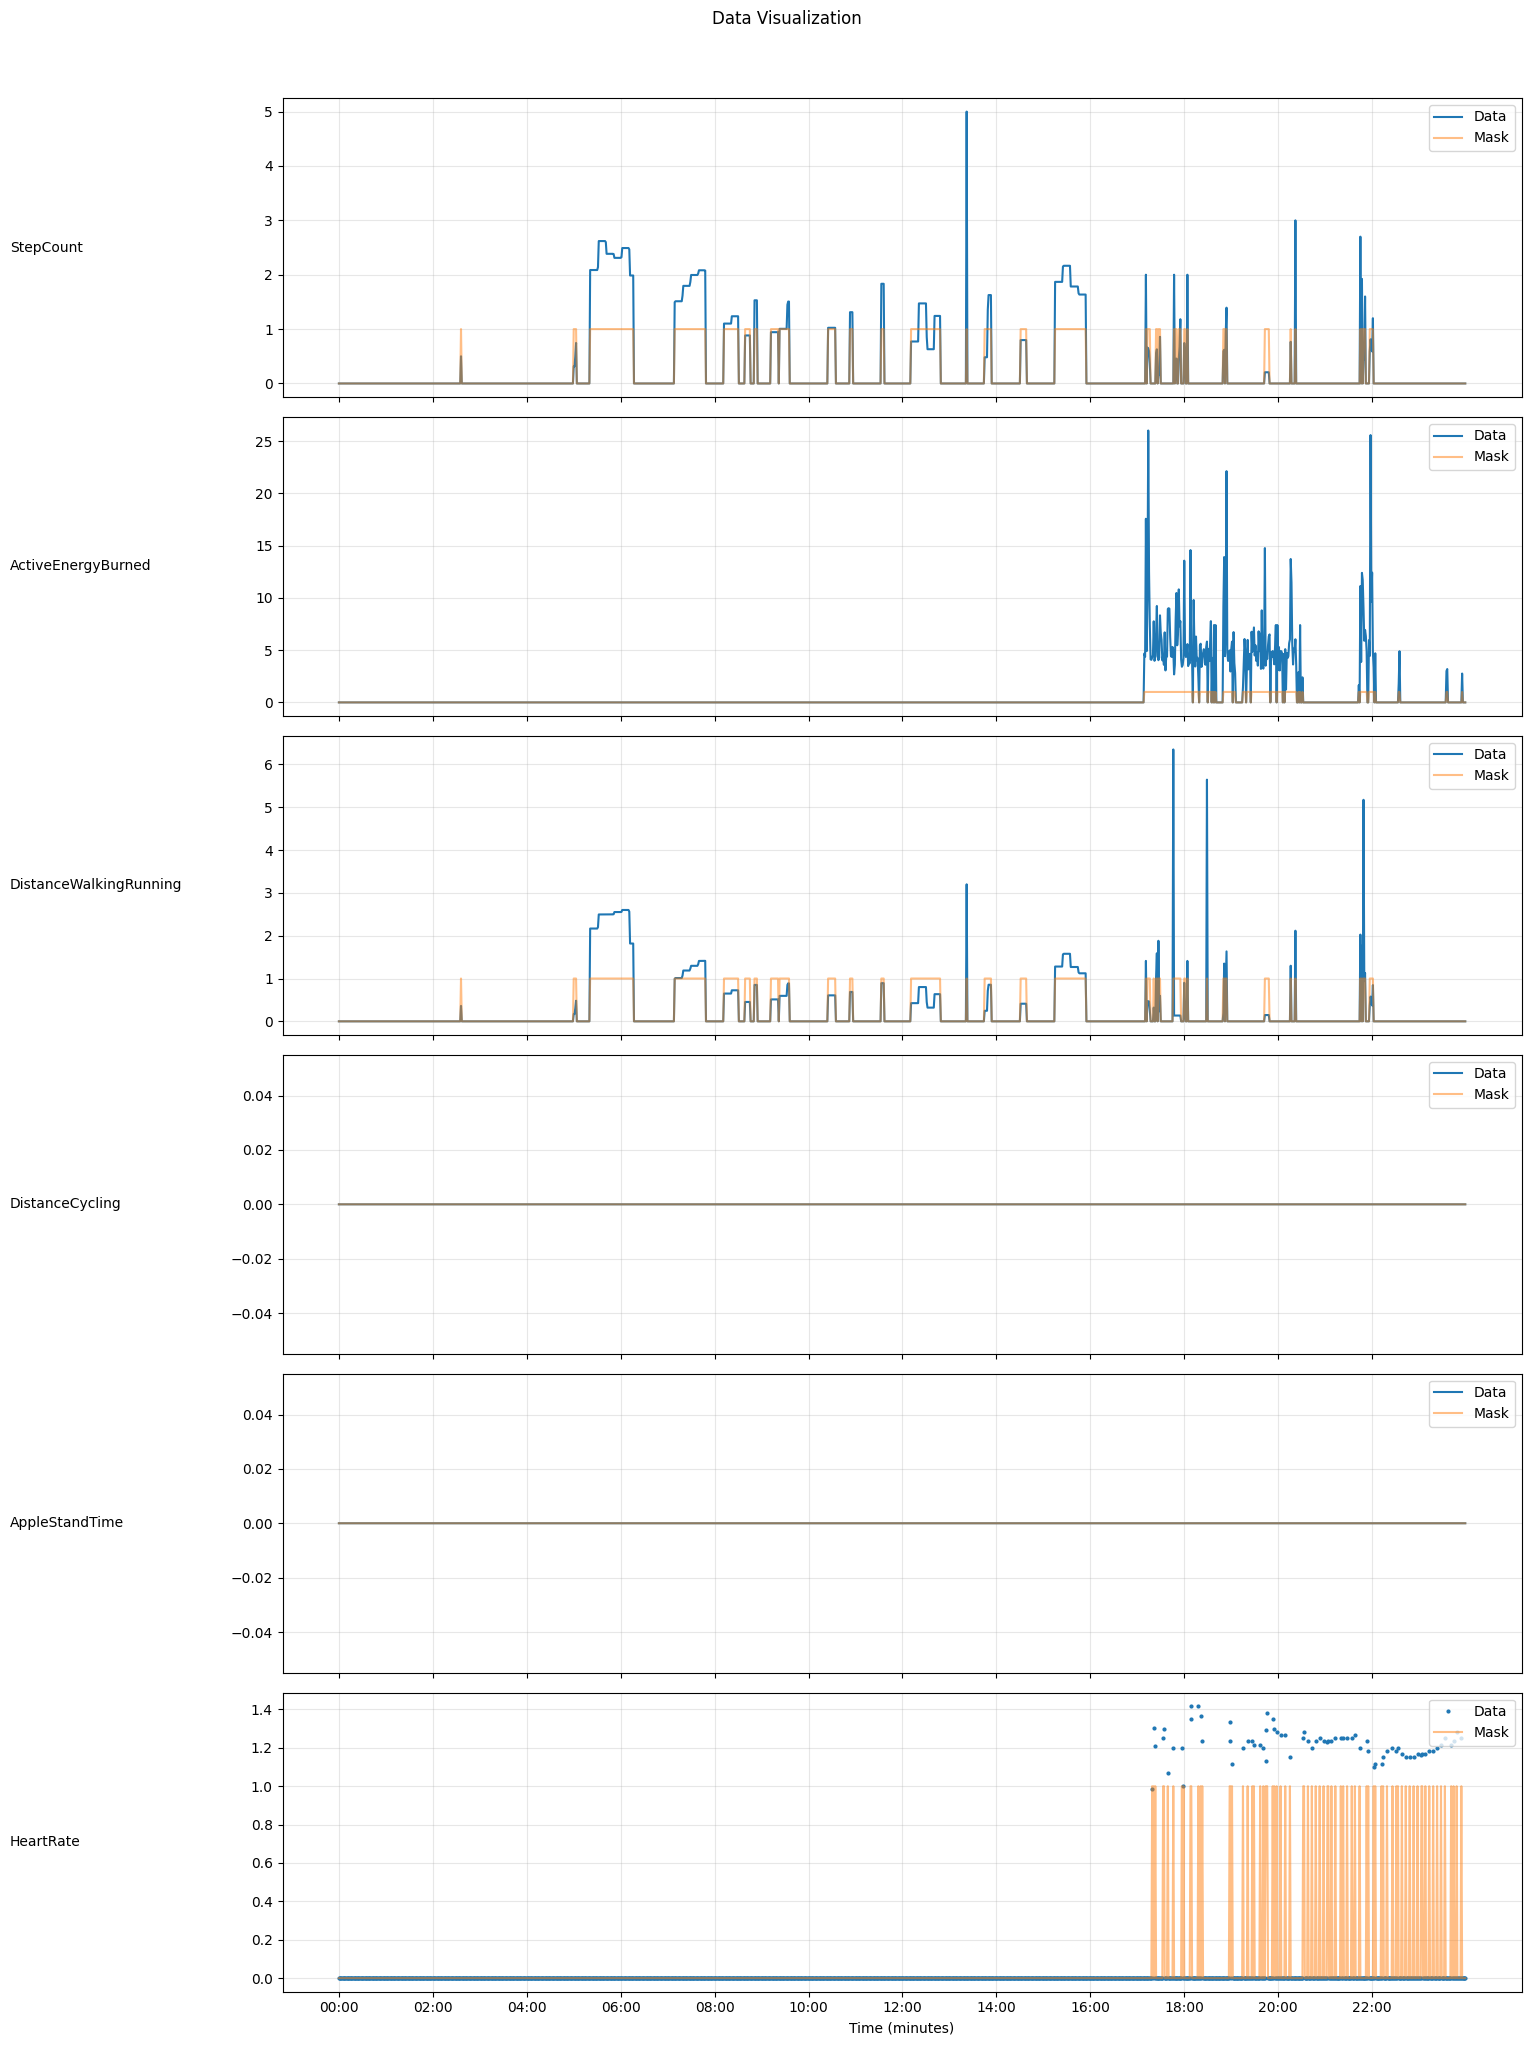

In [15]:
from plots.visualize_npy_matrix import visualize_data_mask_arrays
torch_dataset[0]["data"]

visualize_data_mask_arrays(torch_dataset[0]["data"][0].numpy(), torch_dataset[0]["mask"][0].numpy())



In [22]:
import pandas as pd
from dataset_postprocessors import CustomMaskPostprocessor, HeartRateInterpolationPostprocessor

df = pd.read_parquet('/mnt/shared/mhc_dataset_out/splits/test_dataset.parquet')
standardization_df = pd.read_csv("/mnt/shared/mhc_dataset_out/standardization_params.csv")

df.file_uris = df.file_uris.apply(eval)

dataset_df = df.head(50)

scaler_stats = {}
for f_idx, row in standardization_df.iloc[:6].iterrows():
    scaler_stats[f_idx] = (row["mean"], row["std_dev"])

p0 = CustomMaskPostprocessor(heart_rate_original_index=5, expected_raw_features=6)
p1 = HeartRateInterpolationPostprocessor(heart_rate_original_index=5, expected_raw_features=6)

In [ ]:
import sys
import os
import logging
import datasets

# Add the src directory to the Python path to import the modules
# Adjust the path if your notebook is not directly in the 'notebooks' directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.torch_dataset import FlattenedMhcDataset
from src.huggingface_dataset import create_and_save_hf_dataset_as_gluonTS_style

# --- Configuration ---
# Configure logging

logging.basicConfig(level=logging.ERROR, format='%(asctime)s - %(levelname)s - [%(name)s] %(message)s')
logger = logging.getLogger(__name__)



# Define the root directory where the .npy files are located
# Adjust this path based on where your data files corresponding to 'file_uris' actually are
root_dir = '/mnt/shared/mhc_dataset/' 

# Define where to save the Hugging Face dataset
output_hf_dataset_path = "/mnt/nvme/mhc_test_hf" #test_hf

cache_dir = "/mnt/nvme/mhc_test_hf_cache"

# Determine feature selection (set to None to use all features)
# If you want specific features, provide a list of indices: e.g., [0, 1, 5]
selected_features = list(range(6)) 

# Decide whether to include mask data (assumes it exists in the source .npy files)
include_mask = True
feature_stats = scaler_stats
# --- Dataset Creation ---
logger.info("Starting Hugging Face dataset conversion process...")

# 1. Instantiate the FlattenedMhcDataset
logger.info(f"Loading FlattenedMhcDataset with root directory: {root_dir}")
try:
    # Use the dataset_df you loaded earlier
    torch_dataset = FlattenedMhcDataset(
        dataframe=dataset_df, # Using the dataframe loaded in the previous cell
        root_dir=root_dir,
        include_mask=include_mask,
        feature_indices=selected_features,
        use_cache=False, # Disable caching for this potentially small/test dataset
        #feature_stats=feature_stats
        postprocessors=[p0, p1]
    )
    logger.info(f"Successfully instantiated FlattenedMhcDataset with {len(torch_dataset)} samples.")
    
    # Optional: Check the first sample
    if len(torch_dataset) > 0:
        sample0 = torch_dataset[0]
        logger.info(f"Sample 0 data shape: {sample0['data'].shape}")
        if include_mask:
             logger.info(f"Sample 0 mask shape: {sample0['mask'].shape}")
    else:
        logger.warning("The created torch_dataset is empty!")

except Exception as e:
    logger.error(f"Error instantiating FlattenedMhcDataset: {e}", exc_info=True)
    raise # Re-raise the exception to stop execution if dataset loading fails

# 2. Create and Save the Hugging Face Dataset
logger.info(f"Attempting to create and save Hugging Face dataset to: {output_hf_dataset_path}")
try:
    create_and_save_hf_dataset_as_gluonTS_style(
        torch_dataset=torch_dataset,
        save_path=output_hf_dataset_path,
        # num_features will be inferred if None, otherwise provide it:
        # num_features=len(selected_features) if selected_features else None, 
        num_features=None, # Let the function try to infer
        include_mask_as_dynamic_feature=False,
        # Optional arguments (uncomment/adjust if needed):
        cache_dir=cache_dir, 
        # num_proc=8, 
        keep_in_memory=False,
        set_masked_target_to_nan=False,
    )
    logger.info("Successfully created and saved Hugging Face dataset.")

    # 3. Verification (Optional)
    logger.info(f"Verifying saved dataset at {output_hf_dataset_path}...")
    reloaded_dataset = datasets.load_from_disk(output_hf_dataset_path)
    print("\nReloaded Hugging Face Dataset Info:")
    print(reloaded_dataset)
    if len(reloaded_dataset) > 0:
        print("\nFirst sample from reloaded dataset:")
        print(reloaded_dataset[0])
    else:
        print("\nReloaded dataset is empty.")

except FileNotFoundError as e:
     logger.error(f"FileNotFoundError during dataset creation/saving: {e}. "
                  f"Check if the 'root_dir' ('{root_dir}') is correct and "
                  f"if the '.npy' files listed in 'dataset_df' exist at the expected locations.", exc_info=True)
except ValueError as e:
     logger.error(f"ValueError during dataset creation/saving: {e}. "
                  f"This might be due to issues inferring 'num_features' or problems with the data shapes.", exc_info=True)
except Exception as e:
    logger.error(f"An unexpected error occurred during Hugging Face dataset creation/saving: {e}", exc_info=True)



Generating train split: 3993 examples [03:32, 125.64 examples/s]IOStream.flush timed out
Generating train split: 6998 examples [04:57, 85.06 examples/s] IOStream.flush timed out
Generating train split: 9994 examples [06:22, 140.88 examples/s]IOStream.flush timed out
Generating train split: 12997 examples [07:47, 144.81 examples/s]IOStream.flush timed out
Generating train split: 15995 examples [09:12, 144.47 examples/s]IOStream.flush timed out
Generating train split: 19994 examples [11:06, 139.98 examples/s]IOStream.flush timed out
Generating train split: 26996 examples [14:26, 144.55 examples/s]IOStream.flush timed out
Generating train split: 30992 examples [16:20, 139.72 examples/s]IOStream.flush timed out
Generating train split: 31994 examples [16:48, 143.45 examples/s]IOStream.flush timed out
Generating train split: 32997 examples [17:17, 141.35 examples/s]IOStream.flush timed out
Generating train split: 38754 examples [20:11, 31.99 examples/s] 
Saving the dataset (19/19 shards): 10


Reloaded Hugging Face Dataset Info:
Dataset({
    features: ['target', 'start', 'freq', 'item_id', 'feat_static_real'],
    num_rows: 38754
})

First sample from reloaded dataset:
{'target': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0

In [18]:
import pandas as pd
from dataset_postprocessors import CustomMaskPostprocessor, HeartRateInterpolationPostprocessor

df = pd.read_parquet('/mnt/shared/mhc_dataset_out/splits/train_final_dataset.parquet')
standardization_df = pd.read_csv("/mnt/shared/mhc_dataset_out/standardization_params.csv")

df.file_uris = df.file_uris.apply(eval)

dataset_df = df#.head(50)

scaler_stats = {}
for f_idx, row in standardization_df.iloc[:6].iterrows():
    scaler_stats[f_idx] = (row["mean"], row["std_dev"])

p0 = CustomMaskPostprocessor(heart_rate_original_index=5, expected_raw_features=6)
p1 = HeartRateInterpolationPostprocessor(heart_rate_original_index=5, expected_raw_features=6)

In [19]:
import sys
import os
import logging
import datasets

# Add the src directory to the Python path to import the modules
# Adjust the path if your notebook is not directly in the 'notebooks' directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.torch_dataset import FlattenedMhcDataset
from src.huggingface_dataset import create_and_save_hf_dataset_as_gluonTS_style

# --- Configuration ---
# Configure logging

logging.basicConfig(level=logging.ERROR, format='%(asctime)s - %(levelname)s - [%(name)s] %(message)s')
logger = logging.getLogger(__name__)



# Define the root directory where the .npy files are located
# Adjust this path based on where your data files corresponding to 'file_uris' actually are
root_dir = '/mnt/shared/mhc_dataset/' 

# Define where to save the Hugging Face dataset
output_hf_dataset_path = "/mnt/nvme/mhc_train_hf" #test_hf

cache_dir = "/mnt/nvme/mhc_train_hf_cache"

# Determine feature selection (set to None to use all features)
# If you want specific features, provide a list of indices: e.g., [0, 1, 5]
selected_features = list(range(6)) 

# Decide whether to include mask data (assumes it exists in the source .npy files)
include_mask = True
feature_stats = scaler_stats
# --- Dataset Creation ---
logger.info("Starting Hugging Face dataset conversion process...")

# 1. Instantiate the FlattenedMhcDataset
logger.info(f"Loading FlattenedMhcDataset with root directory: {root_dir}")
try:
    # Use the dataset_df you loaded earlier
    torch_dataset = FlattenedMhcDataset(
        dataframe=dataset_df, # Using the dataframe loaded in the previous cell
        root_dir=root_dir,
        include_mask=include_mask,
        feature_indices=selected_features,
        use_cache=False, # Disable caching for this potentially small/test dataset
        #feature_stats=feature_stats
        postprocessors=[p0, p1]
    )
    logger.info(f"Successfully instantiated FlattenedMhcDataset with {len(torch_dataset)} samples.")
    
    # Optional: Check the first sample
    if len(torch_dataset) > 0:
        sample0 = torch_dataset[0]
        logger.info(f"Sample 0 data shape: {sample0['data'].shape}")
        if include_mask:
             logger.info(f"Sample 0 mask shape: {sample0['mask'].shape}")
    else:
        logger.warning("The created torch_dataset is empty!")

except Exception as e:
    logger.error(f"Error instantiating FlattenedMhcDataset: {e}", exc_info=True)
    raise # Re-raise the exception to stop execution if dataset loading fails

# 2. Create and Save the Hugging Face Dataset
logger.info(f"Attempting to create and save Hugging Face dataset to: {output_hf_dataset_path}")
try:
    create_and_save_hf_dataset_as_gluonTS_style(
        torch_dataset=torch_dataset,
        save_path=output_hf_dataset_path,
        # num_features will be inferred if None, otherwise provide it:
        # num_features=len(selected_features) if selected_features else None, 
        num_features=None, # Let the function try to infer
        include_mask_as_dynamic_feature=False,
        # Optional arguments (uncomment/adjust if needed):
        cache_dir=cache_dir, 
        # num_proc=8, 
        keep_in_memory=False,
        set_masked_target_to_nan=False,
    )
    logger.info("Successfully created and saved Hugging Face dataset.")

    # 3. Verification (Optional)
    logger.info(f"Verifying saved dataset at {output_hf_dataset_path}...")
    reloaded_dataset = datasets.load_from_disk(output_hf_dataset_path)
    print("\nReloaded Hugging Face Dataset Info:")
    print(reloaded_dataset)
    if len(reloaded_dataset) > 0:
        print("\nFirst sample from reloaded dataset:")
        print(reloaded_dataset[0])
    else:
        print("\nReloaded dataset is empty.")

except FileNotFoundError as e:
     logger.error(f"FileNotFoundError during dataset creation/saving: {e}. "
                  f"Check if the 'root_dir' ('{root_dir}') is correct and "
                  f"if the '.npy' files listed in 'dataset_df' exist at the expected locations.", exc_info=True)
except ValueError as e:
     logger.error(f"ValueError during dataset creation/saving: {e}. "
                  f"This might be due to issues inferring 'num_features' or problems with the data shapes.", exc_info=True)
except Exception as e:
    logger.error(f"An unexpected error occurred during Hugging Face dataset creation/saving: {e}", exc_info=True)



Generating train split: 30992 examples [18:36, 144.82 examples/s]IOStream.flush timed out
Generating train split: 91998 examples [47:53, 121.01 examples/s]IOStream.flush timed out
Generating train split: 111992 examples [57:29, 144.97 examples/s]IOStream.flush timed out
Generating train split: 130992 examples [1:06:34, 142.55 examples/s]IOStream.flush timed out
Generating train split: 137995 examples [1:09:56, 141.01 examples/s]IOStream.flush timed out
Generating train split: 138723 examples [1:10:28, 32.81 examples/s] 
Saving the dataset (68/68 shards): 100%|██████████| 138723/138723 [02:05<00:00, 1106.92 examples/s]



Reloaded Hugging Face Dataset Info:
Dataset({
    features: ['target', 'start', 'freq', 'item_id', 'feat_static_real'],
    num_rows: 138723
})

First sample from reloaded dataset:
{'target': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.4000000953674316, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [20]:
import pandas as pd
from dataset_postprocessors import CustomMaskPostprocessor, HeartRateInterpolationPostprocessor

df = pd.read_parquet('/mnt/shared/mhc_dataset_out/splits/validation_dataset.parquet')
standardization_df = pd.read_csv("/mnt/shared/mhc_dataset_out/standardization_params.csv")

df.file_uris = df.file_uris.apply(eval)

dataset_df = df#.head(50)

scaler_stats = {}
for f_idx, row in standardization_df.iloc[:6].iterrows():
    scaler_stats[f_idx] = (row["mean"], row["std_dev"])

p0 = CustomMaskPostprocessor(heart_rate_original_index=5, expected_raw_features=6)
p1 = HeartRateInterpolationPostprocessor(heart_rate_original_index=5, expected_raw_features=6)

In [21]:
import sys
import os
import logging
import datasets

# Add the src directory to the Python path to import the modules
# Adjust the path if your notebook is not directly in the 'notebooks' directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.torch_dataset import FlattenedMhcDataset
from src.huggingface_dataset import create_and_save_hf_dataset_as_gluonTS_style

# --- Configuration ---
# Configure logging

logging.basicConfig(level=logging.ERROR, format='%(asctime)s - %(levelname)s - [%(name)s] %(message)s')
logger = logging.getLogger(__name__)



# Define the root directory where the .npy files are located
# Adjust this path based on where your data files corresponding to 'file_uris' actually are
root_dir = '/mnt/shared/mhc_dataset/' 

# Define where to save the Hugging Face dataset
output_hf_dataset_path = "/mnt/nvme/mhc_val_hf" #test_hf

cache_dir = "/mnt/nvme/mhc_val_hf_cache"

# Determine feature selection (set to None to use all features)
# If you want specific features, provide a list of indices: e.g., [0, 1, 5]
selected_features = list(range(6)) 

# Decide whether to include mask data (assumes it exists in the source .npy files)
include_mask = True
feature_stats = scaler_stats
# --- Dataset Creation ---
logger.info("Starting Hugging Face dataset conversion process...")

# 1. Instantiate the FlattenedMhcDataset
logger.info(f"Loading FlattenedMhcDataset with root directory: {root_dir}")
try:
    # Use the dataset_df you loaded earlier
    torch_dataset = FlattenedMhcDataset(
        dataframe=dataset_df, # Using the dataframe loaded in the previous cell
        root_dir=root_dir,
        include_mask=include_mask,
        feature_indices=selected_features,
        use_cache=False, # Disable caching for this potentially small/test dataset
        #feature_stats=feature_stats
        postprocessors=[p0, p1]
    )
    logger.info(f"Successfully instantiated FlattenedMhcDataset with {len(torch_dataset)} samples.")
    
    # Optional: Check the first sample
    if len(torch_dataset) > 0:
        sample0 = torch_dataset[0]
        logger.info(f"Sample 0 data shape: {sample0['data'].shape}")
        if include_mask:
             logger.info(f"Sample 0 mask shape: {sample0['mask'].shape}")
    else:
        logger.warning("The created torch_dataset is empty!")

except Exception as e:
    logger.error(f"Error instantiating FlattenedMhcDataset: {e}", exc_info=True)
    raise # Re-raise the exception to stop execution if dataset loading fails

# 2. Create and Save the Hugging Face Dataset
logger.info(f"Attempting to create and save Hugging Face dataset to: {output_hf_dataset_path}")
try:
    create_and_save_hf_dataset_as_gluonTS_style(
        torch_dataset=torch_dataset,
        save_path=output_hf_dataset_path,
        # num_features will be inferred if None, otherwise provide it:
        # num_features=len(selected_features) if selected_features else None, 
        num_features=None, # Let the function try to infer
        include_mask_as_dynamic_feature=False,
        # Optional arguments (uncomment/adjust if needed):
        cache_dir=cache_dir, 
        # num_proc=8, 
        keep_in_memory=False,
        set_masked_target_to_nan=False,
    )
    logger.info("Successfully created and saved Hugging Face dataset.")

    # 3. Verification (Optional)
    logger.info(f"Verifying saved dataset at {output_hf_dataset_path}...")
    reloaded_dataset = datasets.load_from_disk(output_hf_dataset_path)
    print("\nReloaded Hugging Face Dataset Info:")
    print(reloaded_dataset)
    if len(reloaded_dataset) > 0:
        print("\nFirst sample from reloaded dataset:")
        print(reloaded_dataset[0])
    else:
        print("\nReloaded dataset is empty.")

except FileNotFoundError as e:
     logger.error(f"FileNotFoundError during dataset creation/saving: {e}. "
                  f"Check if the 'root_dir' ('{root_dir}') is correct and "
                  f"if the '.npy' files listed in 'dataset_df' exist at the expected locations.", exc_info=True)
except ValueError as e:
     logger.error(f"ValueError during dataset creation/saving: {e}. "
                  f"This might be due to issues inferring 'num_features' or problems with the data shapes.", exc_info=True)
except Exception as e:
    logger.error(f"An unexpected error occurred during Hugging Face dataset creation/saving: {e}", exc_info=True)



Generating train split: 823 examples [00:31, 58.09 examples/s]2025-05-07 11:06:25,896 - ERROR - [src.torch_dataset] Could not load or process file /mnt/shared/mhc_dataset/HcENwAk_nnTQPD8nvVaB3YTF/2022-11-07.npy. Error: cannot reshape array of size 37472 into shape (2,24,1440)
2025-05-07 11:06:25,897 - ERROR - [src.torch_dataset] Failed loading/slicing raw file /mnt/shared/mhc_dataset/HcENwAk_nnTQPD8nvVaB3YTF/2022-11-07.npy for sample 826, date 2022-11-07. Using placeholder. Error: Failed to load or process data from /mnt/shared/mhc_dataset/HcENwAk_nnTQPD8nvVaB3YTF/2022-11-07.npy
Generating train split: 17883 examples [08:58, 33.18 examples/s] 
Saving the dataset (9/9 shards): 100%|██████████| 17883/17883 [00:06<00:00, 2682.75 examples/s]


Reloaded Hugging Face Dataset Info:
Dataset({
    features: ['target', 'start', 'freq', 'item_id', 'feat_static_real'],
    num_rows: 17883
})

First sample from reloaded dataset:
{'target': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [9]:
len(dataset_df)

50

In [25]:
import numpy as np
for i in range(len(reloaded_dataset)):
    dt = np.array(reloaded_dataset[i]["target"]).dtype
    if dt != np.float64:
        print(f"Non-float32 dtype found at index {i}: {dt}")


In [15]:
import numpy as np
np.max(np.array(reloaded_dataset[0]["target"])[2])

np.float64(8.345974922180176)

In [4]:
output_hf_dataset_path

'/mnt/nvme/mhc_tmp'